In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px

In [3]:
df = pd.read_csv('binance_nostra_eth_usdc.csv')

In [19]:
df.to_csv('binance_nostra_eth_usdc.csv', index=False)

In [4]:
df.head()

block_number               datetime_utc  price_nostra  price_binance  \
0        514800  2024-01-22 14:05:48+00:00   2385.496183        2387.08   
1        514801  2024-01-22 14:06:51+00:00   2385.496183        2383.72   
2        514802  2024-01-22 14:07:45+00:00   2385.496183        2383.54   
3        514803  2024-01-22 14:08:37+00:00   2385.496183        2385.10   
4        514804  2024-01-22 14:09:51+00:00   2385.496183        2384.90   

   usdc_liquidity  eth_liquidity           mav  
0             2.5       0.001048  2.755069e-07  
1             2.5       0.001048  3.464959e-07  
2             2.5       0.001048  4.202828e-07  
3             2.5       0.001048  1.723910e-08  
4             2.5       0.001048  3.903750e-08

# Theory of Arbitrage and LVR

Price disparities across different trading platforms (both DEXs and CEXs) present arbitrage opportunities. In this section, we calculate the transaction volume required to align prices between AMM-DEX and CEX, given the existing token reserves in an AMM liquidity pool. Trading this volume maximizes the arbitrageur’s profit, which is called net LVR, or the Maximal Arbitrage Value (MAV). For simplicity, we further assume that trading on the CEX has no price impact due to the typically higher reserves compared to AMM-DEXs.

## Maximal Arbitrage Value

Consider a scenario in which there is a price discrepancy between a CEX and an AMM, the CEX having a substantially higher market depth, resulting in zero market impact. Let \(P_c\) and \(P_a\) be the prices at CEX and AMM, respectively, and assume that \(P_c < P_a\). Let \(V_{max}\) denote the maximum trade volume that was bought on the CEX for \(P_c\) and sold on the AMM for \(P_a\) equals the prices. With \(V_{max}\) being the trading volume that equals the prices at AMM and CEX and percentage price impact \(\rho(V_{max})\), MAV is defined as:

$$
MAV = V_{max} \cdot \left( P_a \cdot (1 - \rho(V_{max})) - P_c \right)
$$

or equivalently

$$
MAV = V_{max} \cdot (P_a - P_c) - V_{max} \cdot P_a \cdot \rho(V_{max}).
$$

## Arbitrage between a CPMM and CEX

Let us assume that we have two tokens \(X\) and \(Y\), the respective reserves in the liquidity pool of AMM are \(x_1 = x\) and \(x_2 = y\). Assuming that we are dealing with a CPMM, the act of trading follows the \(x_1 \cdot x_2 = x \cdot y = L\) formula, and the instantaneous exchange rate \(P_a\) for an infinitesimal trade is

$$
P_a = \frac{x}{y}.
$$

and the percentage price impact on a CPMM (such as Uniswap v2) is given by \(\Delta x / x\) for a swap of \(\Delta x\) for \(\Delta y\). The MAV can be expressed as:

$$
MAV = V_{max} \cdot (P_a - P_c) - \frac{V_{max}^2 P_a}{x},
$$

Following \[13, 16\] we can compute the first derivative of Eq. (3) with respect to \(V_{max}\) to find the max points, receiving:

$$
V_{max} = \frac{y \cdot (P_a - P_c)}{2P_a}.
$$

And, by substituting (4) into (3) the MAV is written as:

$$
MAV = \frac{y \cdot (P_a - P_c)^2}{4P_a}.
$$


In [65]:
def mav_cpmm(row):
    y = row['eth_liquidity']
    Pa = row['price_nostra']
    Pc = row['price_binance']
    if Pa == 0.0: return np.nan
    return (y * (Pa - Pc)**2) / (4 * Pa)

In [5]:
def abs_diff(row):
    Pa = row['price_nostra']
    Pc = row['price_binance']
    return abs(Pa - Pc)

In [6]:
df['delta'] = df.apply(abs_diff, axis=1)

In [69]:
df['mav'] = df.apply(mav_cpmm, axis=1)

In [7]:
df.mav.describe()

count    1.219450e+05
mean     1.429993e+00
std      1.157480e+01
min      4.110983e-12
25%      6.610572e-02
50%      3.116398e-01
75%      1.003038e+00
max      2.485569e+03
Name: mav, dtype: float64

In [8]:
df[df.mav > 1000]

block_number               datetime_utc  price_nostra  price_binance  \
81203        596003  2024-02-29 17:01:48+00:00   3918.691811         3445.8   

       usdc_liquidity  eth_liquidity          mav       delta  
81203   682722.947915     174.222159  2485.569306  472.891811

In [25]:
# df['mav'] = df['mav'].round(1)

In [33]:
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])

In [24]:
P99 = df.mav.quantile(0.99)
Q3 = df.mav.quantile(0.75)
Q1 = df.mav.quantile(0.25)

IQR = Q3 - Q1

threshold = Q3 + 1.5 * IQR

upper_outliers = df[df.mav > threshold]

upper_outliers.head()

block_number               datetime_utc  price_nostra  price_binance  \
4206        519006  2024-01-25 11:14:02+00:00   2204.598878        2240.14   
4738        519538  2024-01-26 02:21:17+00:00   2204.598870        2233.89   
4739        519539  2024-01-26 02:22:34+00:00   2204.598870        2234.83   
4740        519540  2024-01-26 02:24:37+00:00   2204.598870        2234.82   
4741        519541  2024-01-26 02:26:39+00:00   2204.598870        2233.05   

      usdc_liquidity  eth_liquidity       mav      delta  
4206    38563.048260      17.492093  2.505616  35.541122  
4738    59950.630937      27.193442  2.645738  29.291130  
4739    59950.630937      27.193442  2.818275  30.231130  
4740    59950.630937      27.193442  2.816411  30.221130  
4741    59950.630937      27.193442  2.496167  28.451130

In [25]:
upper_outliers.describe()

block_number  price_nostra  price_binance  usdc_liquidity  \
count   13105.000000  13105.000000   13105.000000    13105.000000   
mean   576676.571614   3121.022837    3119.801963   453450.815332   
std     29280.826948    473.344529     466.172043   138015.653286   
min    519006.000000   2204.598863    2231.110000    38563.048260   
25%    557620.000000   2911.301476    2916.500000   394637.095940   
50%    571662.000000   2991.278110    2989.640000   454522.443613   
75%    601410.000000   3432.828270    3434.730000   583995.633152   
max    636628.000000   4078.647689    4093.450000   682722.947915   

       eth_liquidity           mav         delta  
count   13105.000000  13105.000000  13105.000000  
mean      145.682949      9.445385     24.686685  
std        44.392824     34.237673     16.933759  
min        17.492093      2.408638      9.751236  
25%       103.423807      3.083057     15.857779  
50%       153.785655      4.248284     20.112754  
75%       179.795475      7.050805     26.621093  
max       264.814412   2485.569306    472.891811

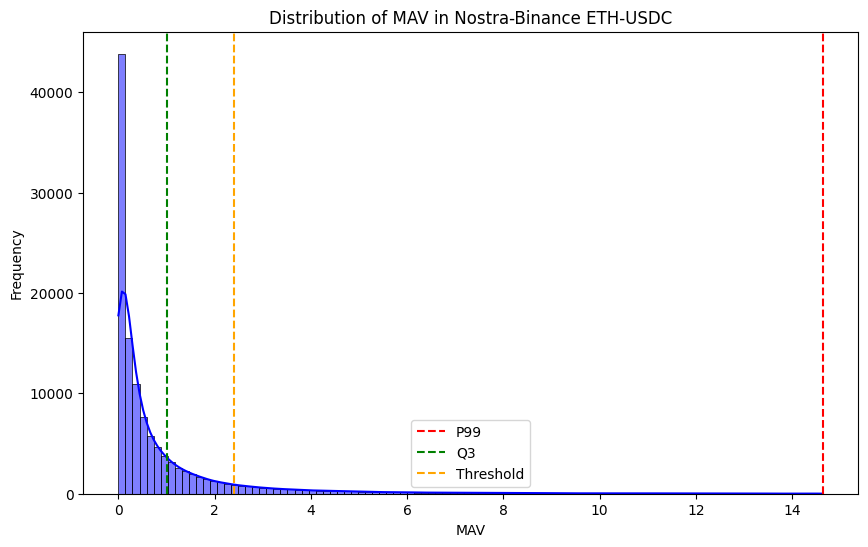

In [56]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df.mav < P99].mav, bins=100, kde=True, color='blue')
plt.title('Distribution of MAV in Nostra-Binance ETH-USDC')
plt.xlabel('MAV')
plt.ylabel('Frequency')
plt.axvline(P99, color='red', linestyle='--', label='P99')
plt.axvline(Q3, color='green', linestyle='--', label='Q3')
plt.axvline(threshold, color='orange', linestyle='--', label='Threshold')
plt.legend()
plt.show()

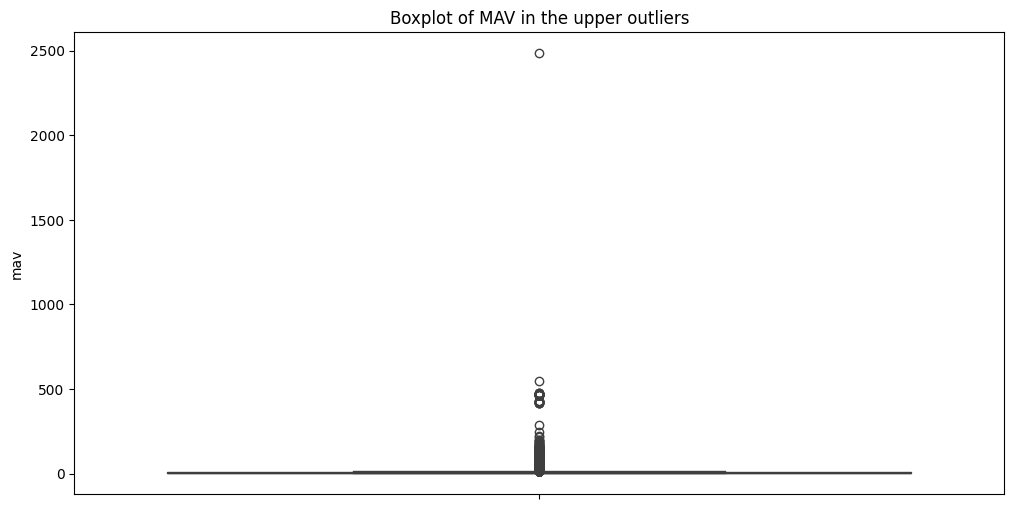

In [54]:
plt.figure(figsize=(12, 6))
sns.boxplot(y='mav', data=upper_outliers)
plt.title('Boxplot of MAV ')
plt.show()

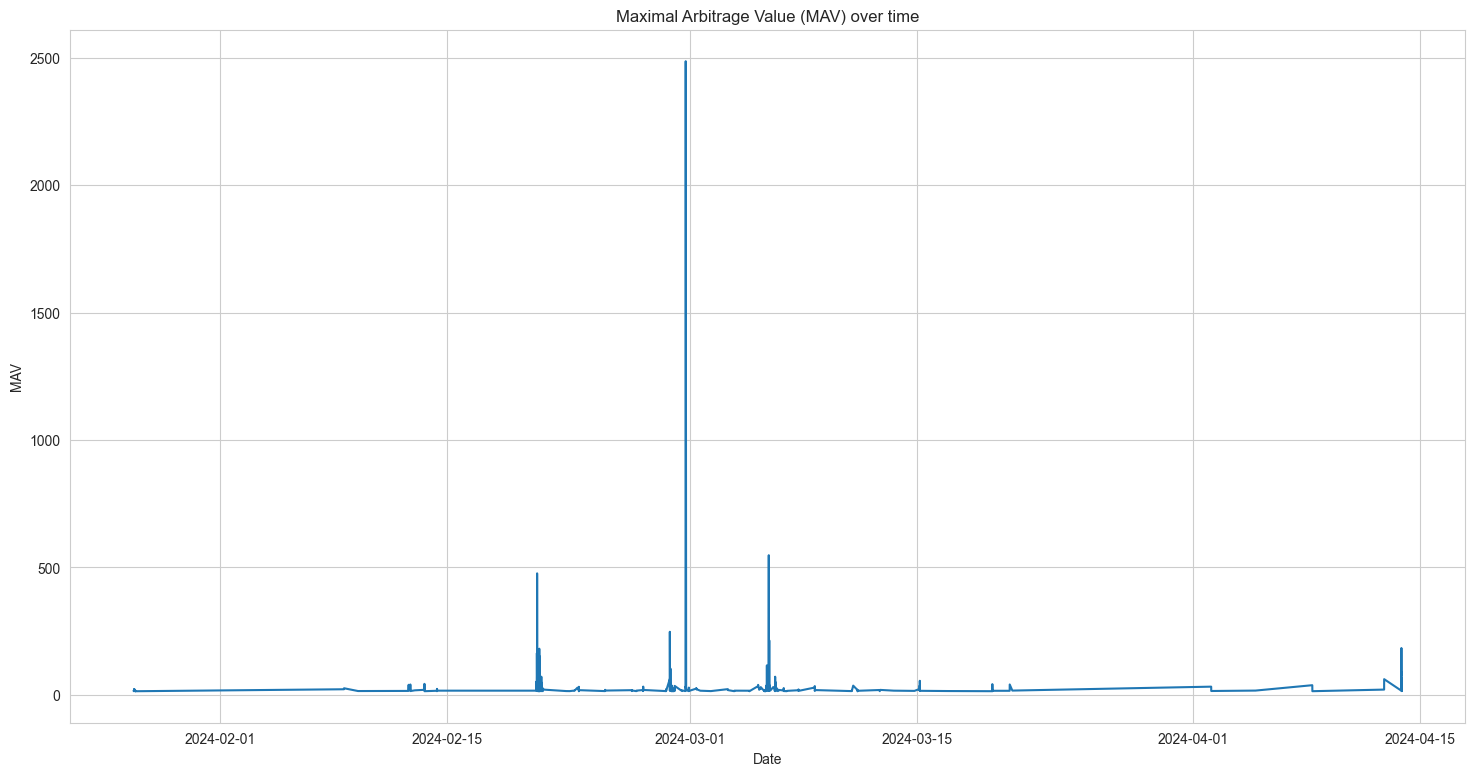

In [67]:
plt.figure(figsize=(18, 9))
plt.plot(upper_outliers['datetime_utc'], upper_outliers['mav'])
plt.title('Maximal Arbitrage Value (MAV) over time')
plt.ylabel('MAV')
plt.xlabel('Date')
plt.show()


In [50]:
max_mav = df[df.mav == df.mav.max()]

max_mav

block_number              datetime_utc  price_nostra  price_binance  \
81203        596003 2024-02-29 17:01:48+00:00   3918.691811         3445.8   

       usdc_liquidity  eth_liquidity     mav  
81203   682722.947915     174.222159  2485.6

In [109]:
total_mav = df.mav.sum()

float(total_mav)


174380.45666355453

In [123]:
data = {
    "Chain": [
        # "Ethereum Uniswap V3",
        "Arbitrum Uniswap V3",
        "Arbitrum (USDC.e) Uniswap V3",
        "Base Uniswap V3",
        "Optimism (USDC.e) Uniswap V3",
        "zkSync Era (USDC.e) Uniswap V3",
        "Starknet Nostra V2"
    ],
    "MAV": [
        # 52488479.88,
        2699032.60,
        2707008.96,
        1293771.96,
        690868.44,
        20110.31,
        total_mav
    ],
    "Volume": [
        # 35175000000,
        7266000000,
        8159000000,
        2996000000,
        1457000000,
        8010000,
        5624289.81,
    ]
}

df_mav = pd.DataFrame(data)
df_mav = df_mav.sort_values(by='MAV', ascending=False)
df_mav['mav_normalised'] = (df_mav['MAV'] / df_mav['Volume']) * 100
df_mav

Chain           MAV        Volume  mav_normalised
1    Arbitrum (USDC.e) Uniswap V3  2.707009e+06  8.159000e+09        0.033178
0             Arbitrum Uniswap V3  2.699033e+06  7.266000e+09        0.037146
2                 Base Uniswap V3  1.293772e+06  2.996000e+09        0.043183
3    Optimism (USDC.e) Uniswap V3  6.908684e+05  1.457000e+09        0.047417
5              Starknet Nostra V2  1.743805e+05  5.624290e+06        3.100488
4  zkSync Era (USDC.e) Uniswap V3  2.011031e+04  8.010000e+06        0.251065

In [126]:
fig = px.bar(
    df_mav, 
    y='Chain', 
    x='mav_normalised', 
    title='MAVV by L2 Chain (ETH / USDC) from December 31, 2023 to April 30, 2024', 
    labels={'mav_normalised': 'Normalised MAV ($ per 100$ traded)', 'Chain': 'Chain'},
    color=df_mav['Chain'].apply(lambda x: 'Highlighted' if x == 'Starknet Nostra V2' else 'Normal')
)

fig.update_yaxes(categoryorder='total ascending')
fig.update_layout(showlegend=False)
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_traces(texttemplate='%{x:.3}', textposition='outside')


In [124]:
fig = px.bar(
    df_mav, 
    y='Chain', 
    x='MAV', 
    title='Maximal Arbitrage Value by L2 Chain (ETH / USDC) from December 31, 2023 to April 30, 2024', 
    labels={'MAV': 'MAV', 'Chain': 'Chain'},
    color=df_mav['Chain'].apply(lambda x: 'Highlighted' if x == 'Starknet Nostra V2' else 'Normal')
)

fig.update_yaxes(categoryorder='total ascending')
fig.update_layout(showlegend=False)
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.update_traces(texttemplate='%{x:.2s}', textposition='outside')

fig.show()

In [88]:
fig = px.box(df, y='delta', title='Distribution of USDC Price Difference', labels={'delta': 'Abs Price Diff'})

fig.update_layout(
    xaxis_title='USDC-ETH',
    yaxis_title='Abs Price Diff',
    showlegend=False,
    height=1500
)

In [67]:
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])

In [76]:
df_day = df.groupby(df['datetime_utc'].dt.date).tail(1)

In [69]:
df_day.head()

block_number              datetime_utc  price_nostra  price_binance  \
473         515273 2024-01-22 23:59:54+00:00   2385.499570        2311.32   
2038        516838 2024-01-23 23:58:37+00:00   2204.598903        2240.20   
3714        518514 2024-01-24 23:58:11+00:00   2204.598884        2232.72   
4664        519464 2024-01-25 23:58:30+00:00   2204.598871        2217.15   
5756        520556 2024-01-26 23:58:46+00:00   2246.638273        2266.57   

      usdc_liquidity  eth_liquidity       mav  
473         5.119234       0.002146  0.001238  
2038     6802.250503       3.085482  0.443466  
3714    29613.025081      13.432387  1.204561  
4664    54330.045068      24.643959  0.440237  
5756    90687.975132      40.366078  1.784486

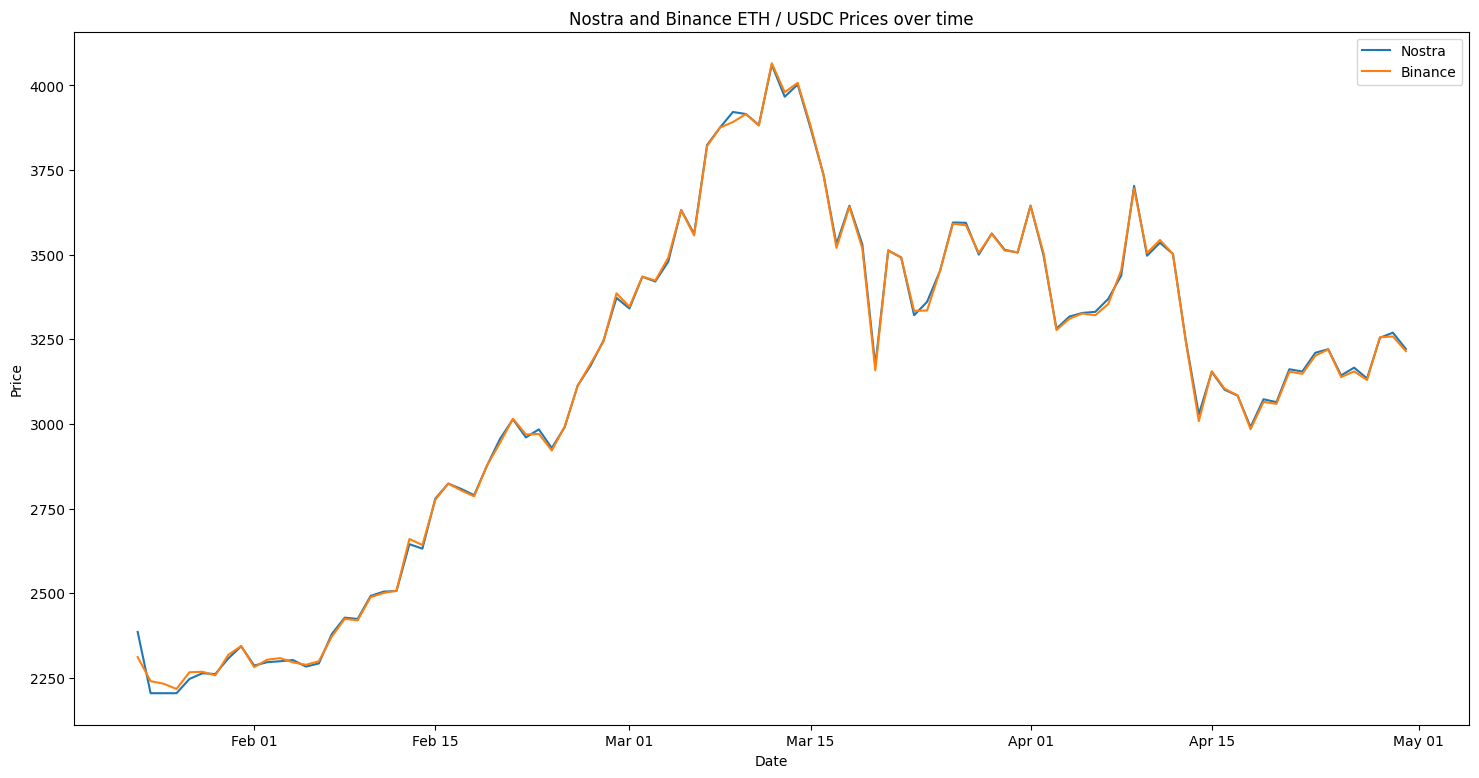

In [73]:

plt.figure(figsize=(18, 9))
plt.plot(df_day['datetime_utc'], df_day['price_nostra'], label='Nostra')
plt.plot(df_day['datetime_utc'], df_day['price_binance'], label='Binance')
plt.title('Nostra and Binance ETH / USDC Prices over time')
plt.ylabel('Price') 
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.legend()
plt.show()

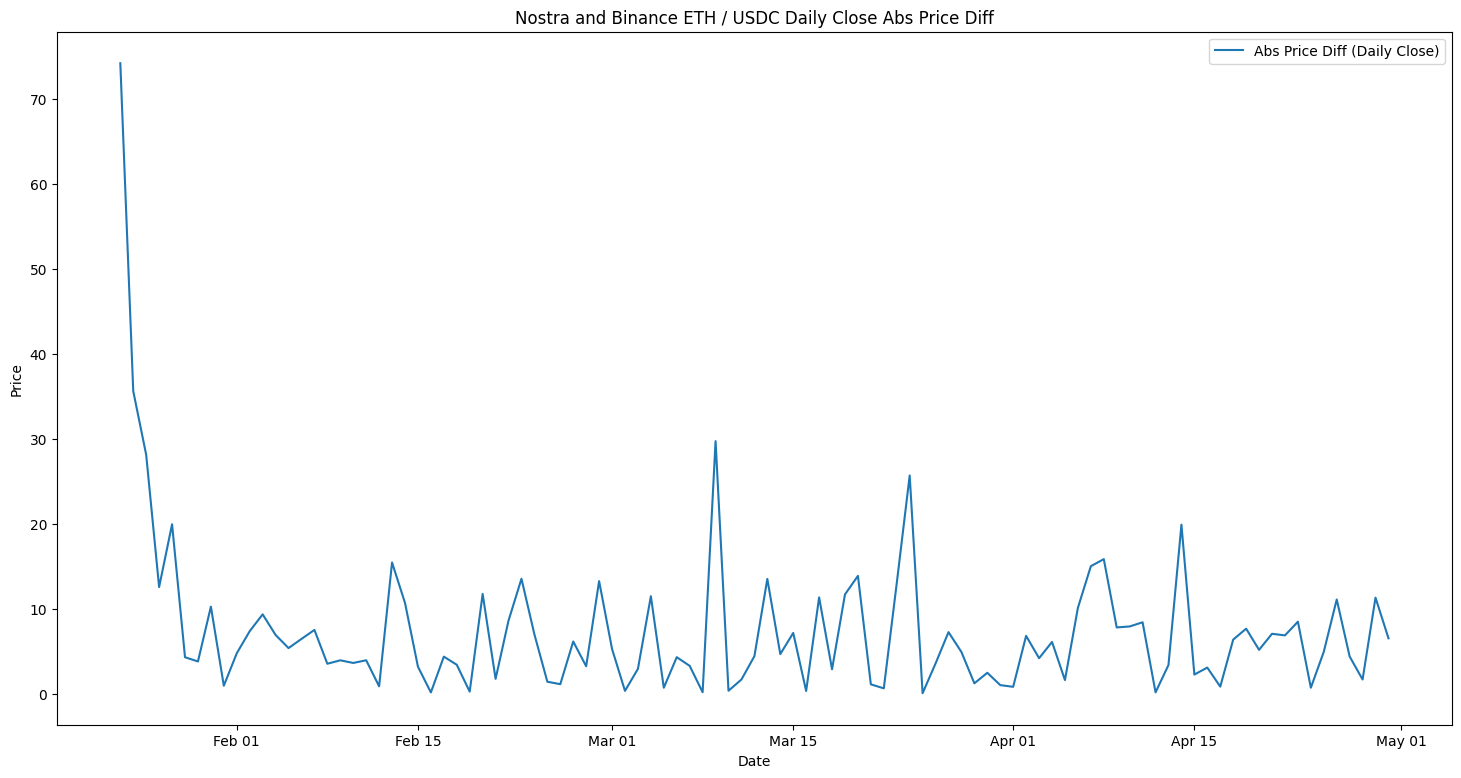

In [83]:
plt.figure(figsize=(18, 9))
plt.plot(df_day['datetime_utc'], df_day['delta'], label='Abs Price Diff (Daily Close)')
plt.title('Nostra and Binance ETH / USDC Daily Close Abs Price Diff')
plt.ylabel('Price') 
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.legend()
plt.show()

In [86]:
starknet_tx = pd.read_csv('daily_tx_starknet.csv')
starknet_tx.block_date = pd.to_datetime(starknet_tx.block_date)

In [87]:
starknet_tx.head()

block_date  starknet_tx_count  zksync_tx_count  \
0 2023-12-31 00:00:00+00:00                901            16389   
1 2024-01-01 00:00:00+00:00                839            14413   
2 2024-01-02 00:00:00+00:00                734             9710   
3 2024-01-03 00:00:00+00:00                634             7294   
4 2024-01-04 00:00:00+00:00                709             7743   

   starknet_user_count  zksync_user_count  starknet_bridged_amount_usd  \
0                  818              14651                 4.968905e+05   
1                  777              12593                 5.264851e+05   
2                  627               8772                 1.251449e+06   
3                  573               6481                 2.811920e+06   
4                  616               6806                 8.531631e+05   

   zksync_bridged_amount_usd  starknet_balance_amount_usd  \
0                42398985.42                -1.861645e+05   
1                27652083.08                -2.130080e+05   
2                17941449.95                 9.967496e+05   
3                29234645.79                 1.860219e+06   
4                20878404.88                -5.325473e+05   

   zksync_balance_amount_usd  
0                20647766.14  
1                 8986585.65  
2               -38716496.31  
3                15320939.89  
4                 7114989.55

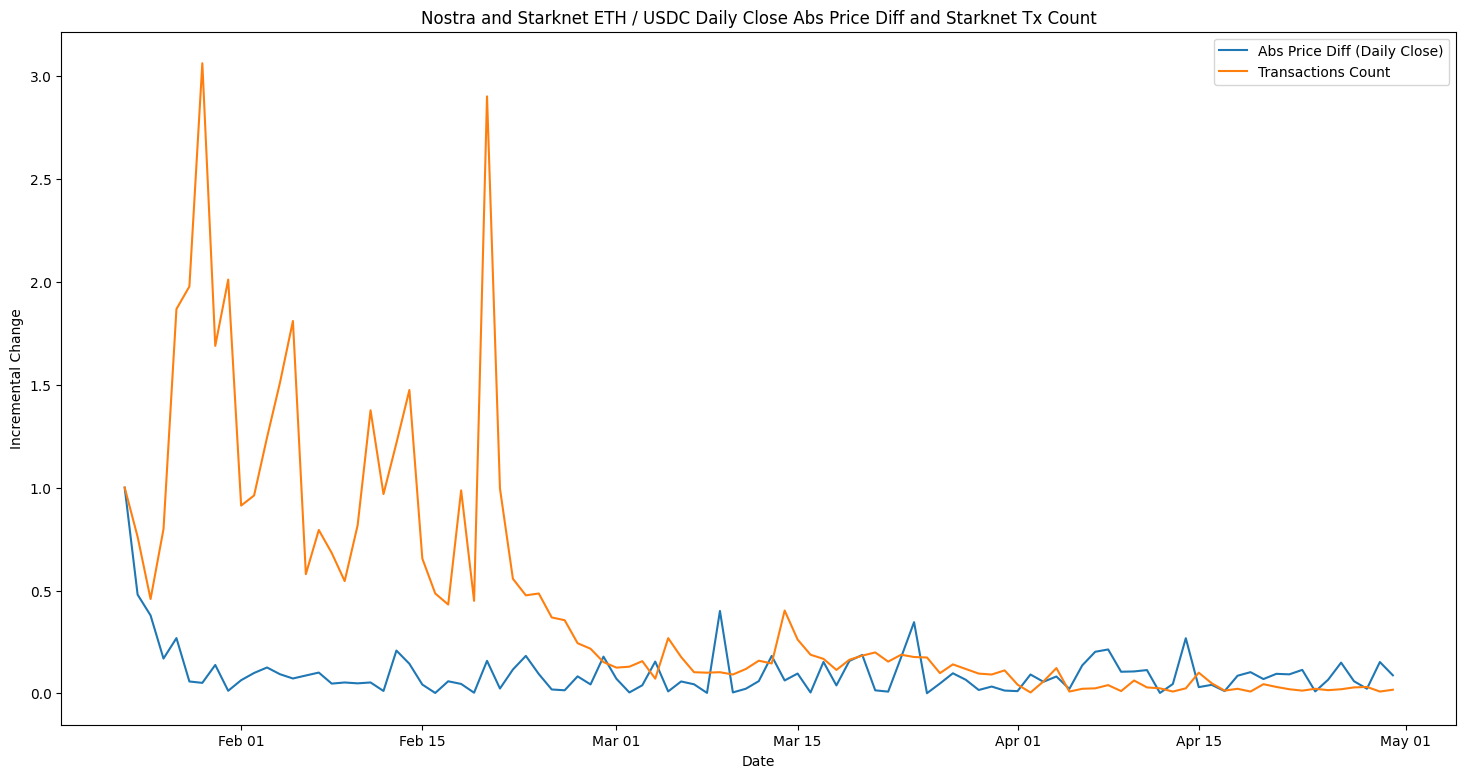

In [105]:
starknet_tx_normalized = starknet_tx['starknet_tx_count'] / starknet_tx['starknet_tx_count'].iloc[0]
df_day_normalized = df_day['delta'] / df_day['delta'].iloc[0]

plt.figure(figsize=(18, 9))
plt.plot(df_day['datetime_utc'], df_day_normalized, label='Abs Price Diff (Daily Close)')
plt.plot(starknet_tx['block_date'], starknet_tx_normalized, label='Transactions Count')
plt.title('Nostra and Starknet ETH / USDC Daily Close Abs Price Diff and Starknet Tx Count')
plt.ylabel('Incremental Change') 
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.legend()
plt.show()

In [10]:
swaps_per_block = pd.read_csv('swaps_per_block.csv')

Outlier #1: Block Number 596003

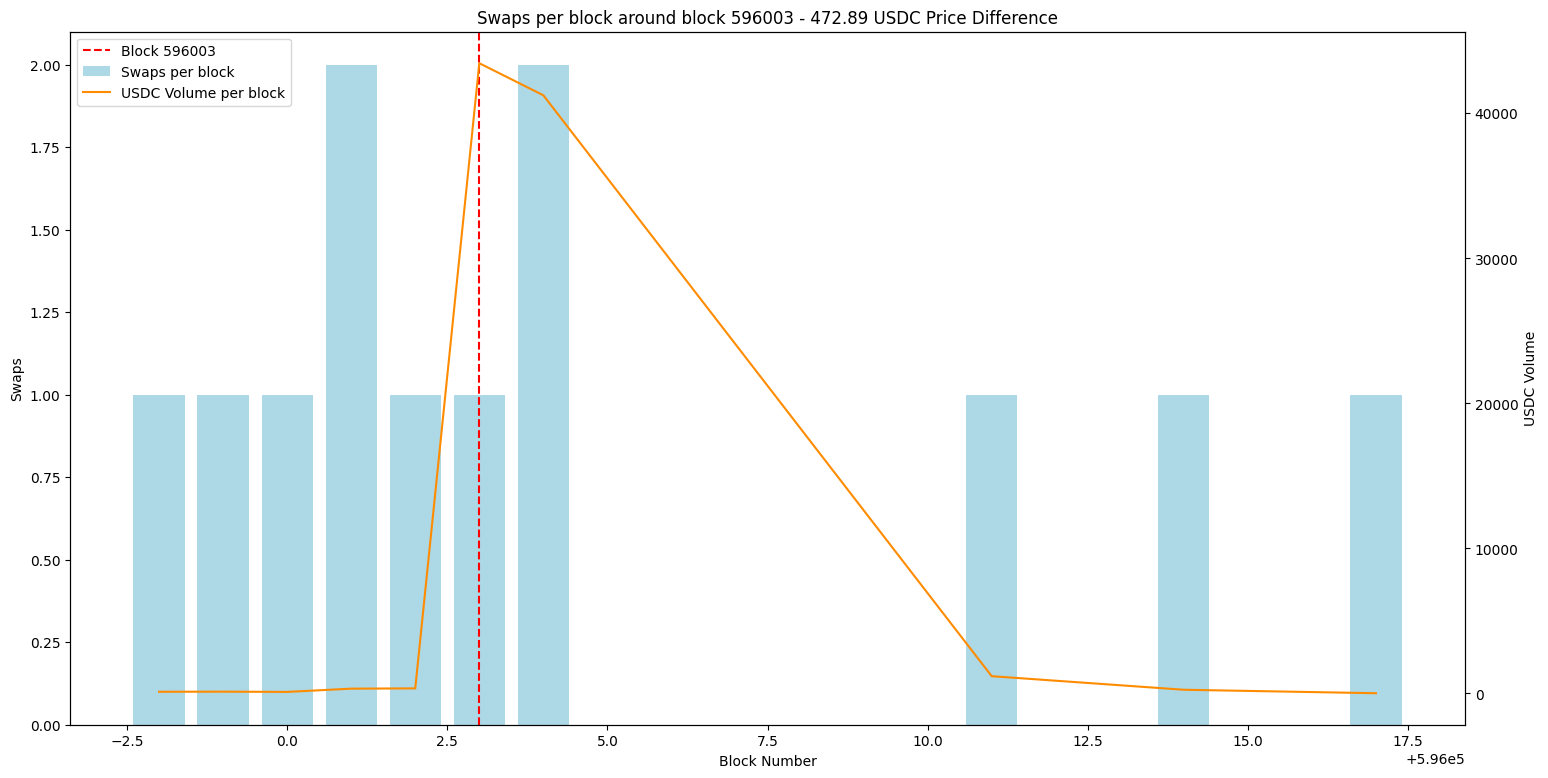

In [63]:
block = 596003
blocks = swaps_per_block[(swaps_per_block['block_number'] >= block - 5) & (swaps_per_block['block_number'] <= block + 15)]

fig, ax1 = plt.subplots(figsize=(18, 9))
ax2 = ax1.twinx()

ax1.bar(blocks['block_number'], blocks['swap_count'], label='Swaps per block', color='lightblue')
ax1.set_ylabel('Swaps')
ax1.set_xlabel('Block Number')

ax2.plot(blocks['block_number'], blocks['usdc_volume'], label='USDC Volume per block', color='darkorange')
ax2.set_ylabel('USDC Volume')

constant_line = block
ax1.axvline(x=constant_line, color='red', linestyle='--', label='Block 596003')

plt.title('Swaps per block around block 596003 - 472.89 USDC Price Difference')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

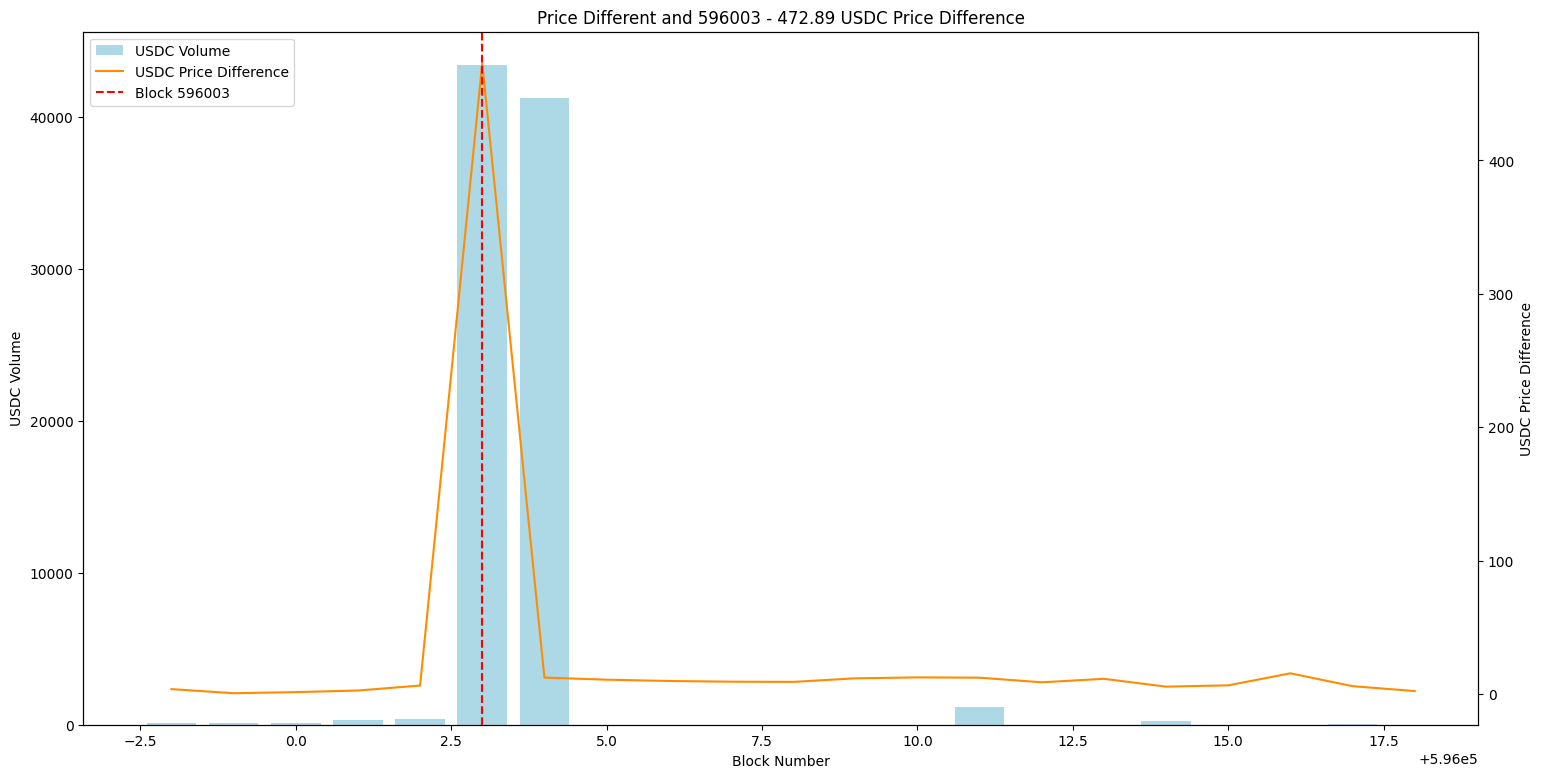

In [68]:
block = 596003
blocks = swaps_per_block[(swaps_per_block['block_number'] >= block - 5) & (swaps_per_block['block_number'] <= block + 15)]
blocks_df = df[(df['block_number'] >= block - 5) & (df['block_number'] <= block + 15)]

fig, ax1 = plt.subplots(figsize=(18, 9))
ax2 = ax1.twinx()

ax1.bar(blocks['block_number'], blocks['usdc_volume'], label='USDC Volume', color='lightblue')
ax1.set_ylabel('USDC Volume')
ax1.set_xlabel('Block Number')

ax2.plot(blocks_df['block_number'], blocks_df['delta'], label='USDC Price Difference', color='darkorange')
ax2.set_ylabel('USDC Price Difference')

constant_line = block
ax2.axvline(x=constant_line, color='red', linestyle='--', label='Block 596003')

plt.title('Price Different and 596003 - 472.89 USDC Price Difference')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

In [47]:
upper_outliers.sort_values(by='mav', ascending=False)

block_number               datetime_utc  price_nostra  price_binance  \
81203         596003  2024-02-29 17:01:48+00:00   3918.691811        3445.80   
86612         601412  2024-03-05 19:57:33+00:00   3470.641212        3260.55   
42630         557430  2024-02-20 13:07:58+00:00   3135.786179        2934.32   
42631         557431  2024-02-20 13:08:07+00:00   3135.786179        2934.81   
42628         557428  2024-02-20 13:07:40+00:00   3135.786179        2935.00   
...              ...                        ...           ...            ...   
50472         565272  2024-02-21 14:18:11+00:00   2906.527125        2892.51   
86109         600909  2024-03-05 06:46:23+00:00   3712.661430        3727.02   
91668         606468  2024-03-11 03:26:34+00:00   3846.005286        3864.99   
43927         558727  2024-02-20 16:05:10+00:00   2937.093680        2923.44   
117185        631985  2024-04-12 19:02:09+00:00   3225.054757        3202.40   

        usdc_liquidity  eth_liquidity          mav       delta  
81203    682722.947915     174.222159  2485.569306  472.891811  
86612    598261.909129     172.377919   548.059480  210.091212  
42630    462271.325153     147.417999   477.032953  201.466179  
42631    462271.325153     147.417999   474.715325  200.976179  
42628    462271.325153     147.417999   473.818171  200.786179  
...                ...            ...          ...         ...  
50472    414350.394051     142.558585     2.409222   14.017125  
86109    644276.620171     173.534978     2.409151   14.358570  
91668    395445.967223     102.819923     2.408882   18.984714  
43927    445840.301849     151.796419     2.408702   13.653680  
117185   195248.160857      60.541037     2.408638   22.654757  

[13105 rows x 8 columns]

Outlier #2: Block 601412

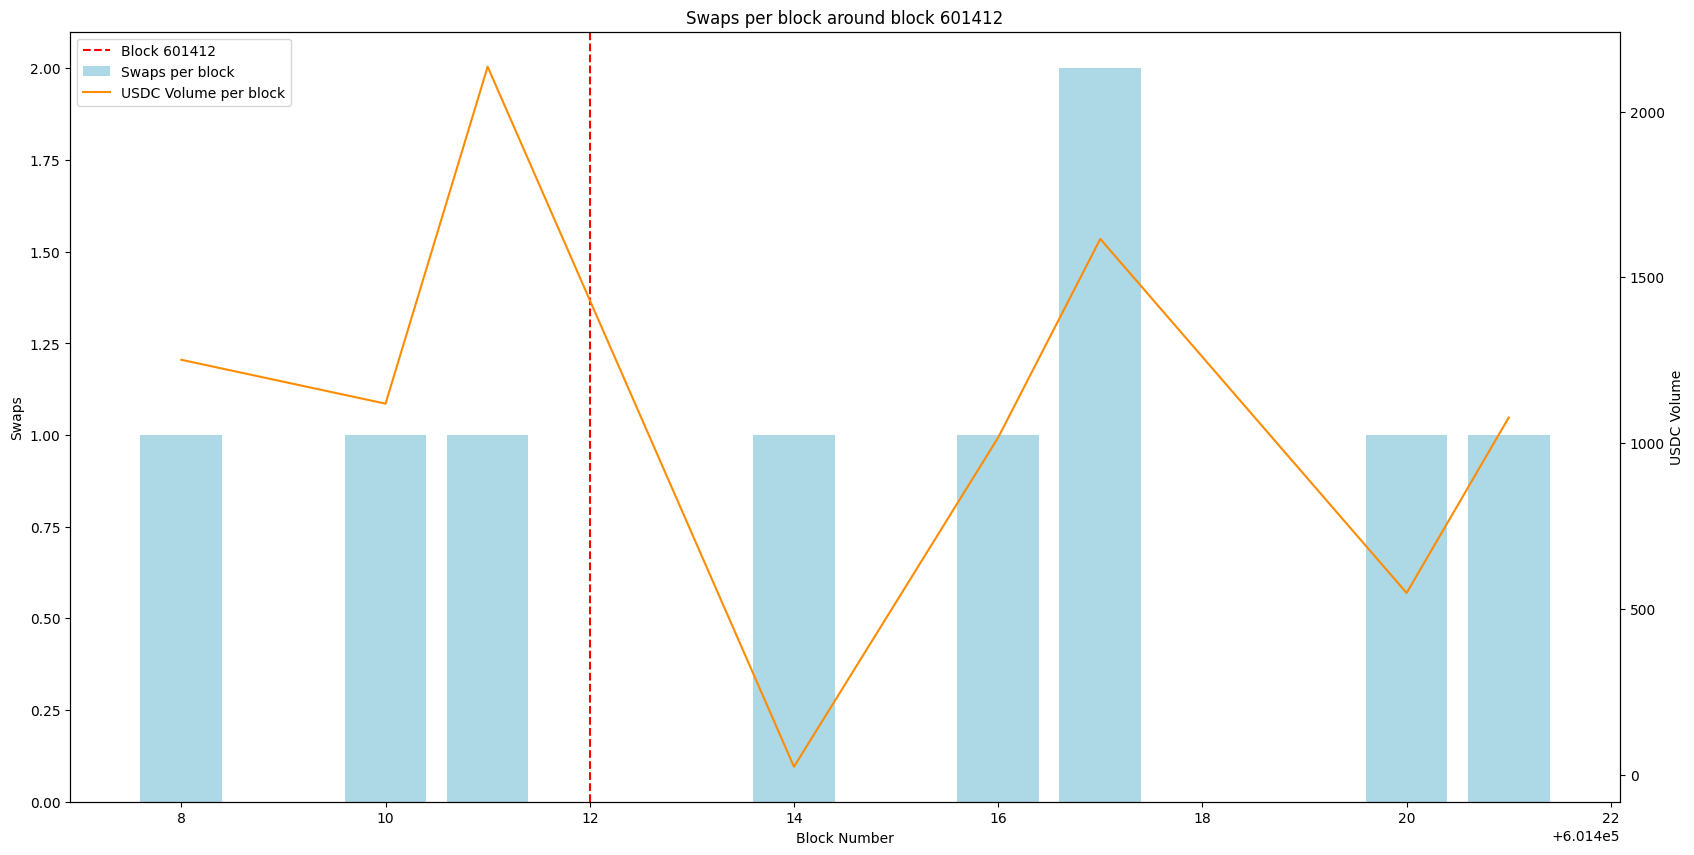

In [59]:
block = 601412
blocks = swaps_per_block[(swaps_per_block['block_number'] >= block - 5) & (swaps_per_block['block_number'] <= block + 15)]

fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()

ax1.bar(blocks['block_number'], blocks['swap_count'], label='Swaps per block', color='lightblue')
ax1.set_ylabel('Swaps')
ax1.set_xlabel('Block Number')

ax2.plot(blocks['block_number'], blocks['usdc_volume'], label='USDC Volume per block', color='darkorange')
ax2.set_ylabel('USDC Volume')

constant_line = block
ax1.axvline(x=constant_line, color='red', linestyle='--', label='Block 601412')

plt.title('Swaps per block around block 601412 - 210.09 USDC Price Difference')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

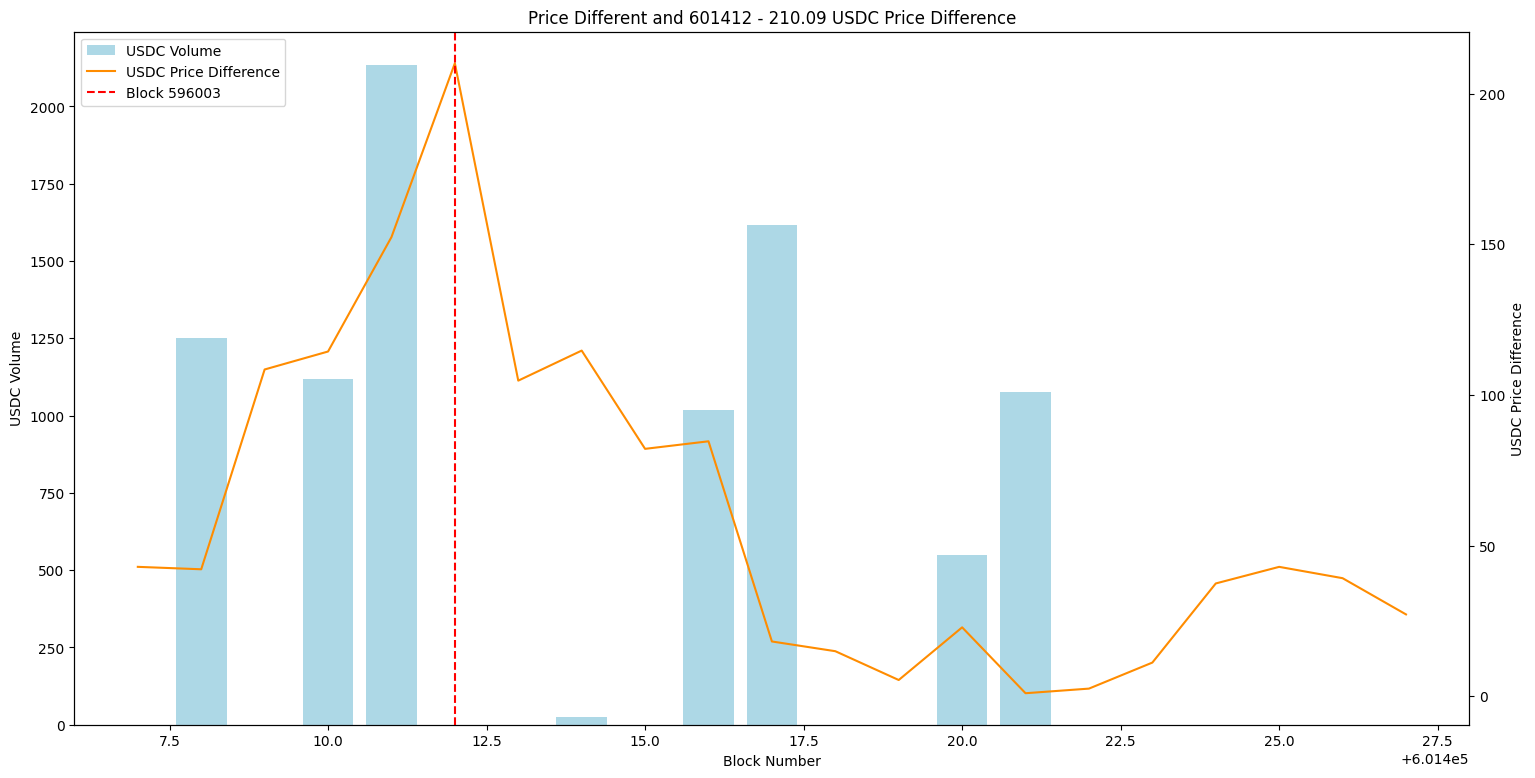

In [70]:
block = 601412
blocks = swaps_per_block[(swaps_per_block['block_number'] >= block - 5) & (swaps_per_block['block_number'] <= block + 15)]
blocks_df = df[(df['block_number'] >= block - 5) & (df['block_number'] <= block + 15)]

fig, ax1 = plt.subplots(figsize=(18, 9))
ax2 = ax1.twinx()

ax1.bar(blocks['block_number'], blocks['usdc_volume'], label='USDC Volume', color='lightblue')
ax1.set_ylabel('USDC Volume')
ax1.set_xlabel('Block Number')

ax2.plot(blocks_df['block_number'], blocks_df['delta'], label='USDC Price Difference', color='darkorange')
ax2.set_ylabel('USDC Price Difference')

constant_line = block
ax2.axvline(x=constant_line, color='red', linestyle='--', label='Block 596003')

plt.title('Price Different and 601412 - 210.09 USDC Price Difference')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

Outlier #3: Block 557430

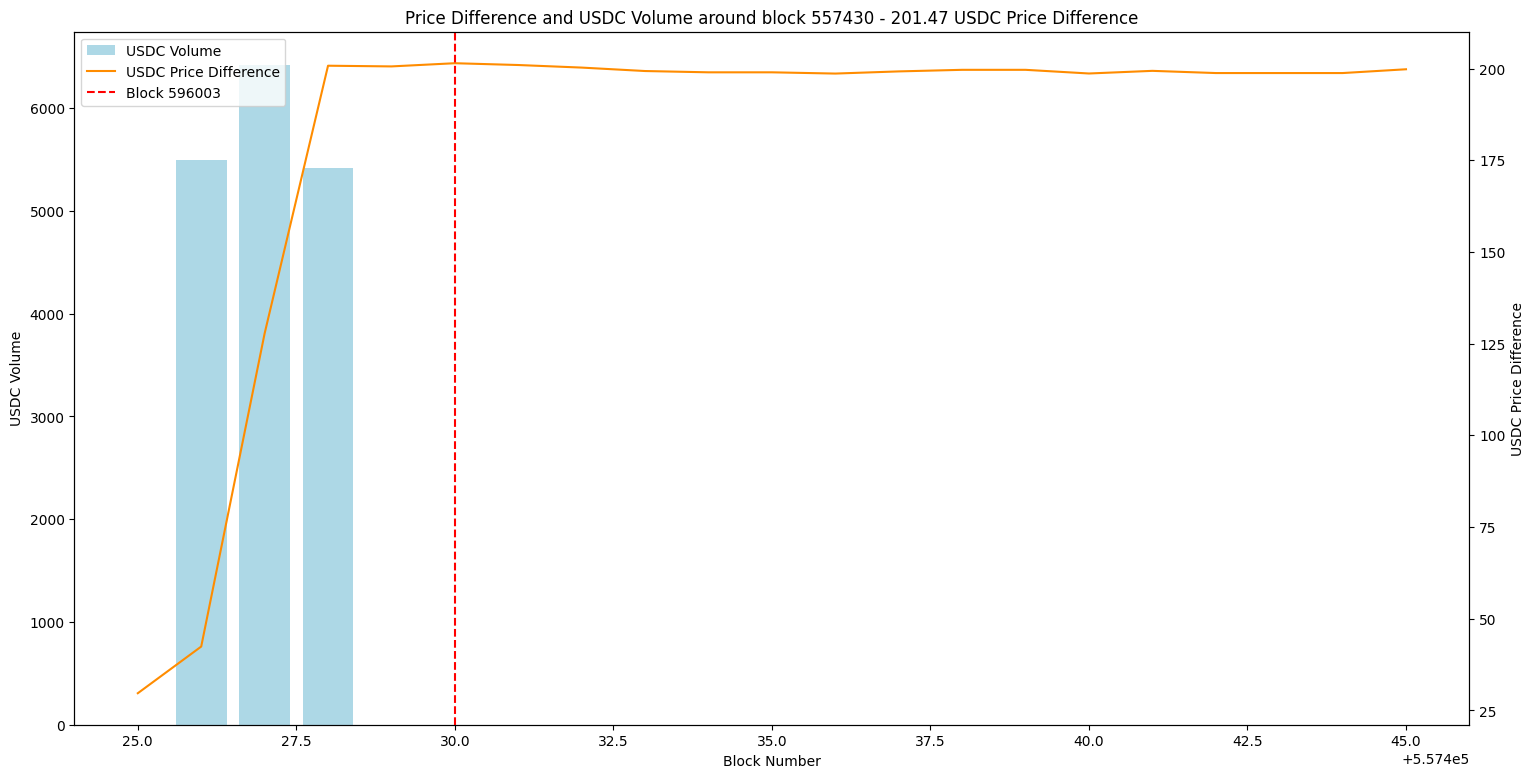

In [73]:
block = 557430
blocks = swaps_per_block[(swaps_per_block['block_number'] >= block - 5) & (swaps_per_block['block_number'] <= block + 15)]
blocks_df = df[(df['block_number'] >= block - 5) & (df['block_number'] <= block + 15)]

fig, ax1 = plt.subplots(figsize=(18, 9))
ax2 = ax1.twinx()

ax1.bar(blocks['block_number'], blocks['usdc_volume'], label='USDC Volume', color='lightblue')
ax1.set_ylabel('USDC Volume')
ax1.set_xlabel('Block Number')

ax2.plot(blocks_df['block_number'], blocks_df['delta'], label='USDC Price Difference', color='darkorange')
ax2.set_ylabel('USDC Price Difference')

constant_line = block
ax2.axvline(x=constant_line, color='red', linestyle='--', label='Block 596003')

plt.title('Price Difference and USDC Volume around block 557430 - 201.47 USDC Price Difference')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.show()

In [75]:
swaps_per_block['datetime'].max()

Timestamp('2024-04-30 21:41:30')

In [76]:
total_swaps = swaps_per_block['swap_count'].sum()
total_usdc_volume = swaps_per_block['usdc_volume'].sum()

In [79]:
int(total_swaps), float(total_usdc_volume)

(47453, 5624289.815031)

In [80]:
total_usdc_volume / total_swaps

np.float64(118.52337713170928)

In [81]:
swaps_per_block.swap_count.mean()

np.float64(1.7087249288826474)

In [84]:
float(swaps_per_block.usdc_volume.mean()), float(swaps_per_block.usdc_volume.median()), float(swaps_per_block.usdc_volume.std())

(202.52384916031113, 72.845478, 562.9582942024904)

In [89]:

float(swaps_per_block.swap_count.mean()), float(swaps_per_block.swap_count.median()), float(swaps_per_block.swap_count.max())

(1.7087249288826474, 1.0, 29.0)

In [93]:
swaps_per_block['block_number'].max() - swaps_per_block['block_number'].min()

np.int64(120750)

In [94]:
swaps_per_block.swap_count.max()

np.int64(29)

In [106]:
upper_outliers.sort_values(by='mav', ascending=False).head()

block_number               datetime_utc  price_nostra  price_binance  \
81203        596003  2024-02-29 17:01:48+00:00   3918.691811        3445.80   
86612        601412  2024-03-05 19:57:33+00:00   3470.641212        3260.55   
42630        557430  2024-02-20 13:07:58+00:00   3135.786179        2934.32   
42631        557431  2024-02-20 13:08:07+00:00   3135.786179        2934.81   
42628        557428  2024-02-20 13:07:40+00:00   3135.786179        2935.00   

       usdc_liquidity  eth_liquidity          mav       delta    delta_%  
81203   682722.947915     174.222159  2485.569306  472.891811  13.723716  
86612   598261.909129     172.377919   548.059480  210.091212   6.443429  
42630   462271.325153     147.417999   477.032953  201.466179   6.865856  
42631   462271.325153     147.417999   474.715325  200.976179   6.848013  
42628   462271.325153     147.417999   473.818171  200.786179   6.841096

In [105]:
upper_outliers['delta_%'] = upper_outliers['delta'] / upper_outliers['price_binance'] * 100

/var/folders/zp/9kkn3ltx55q4wz7hp7q19ggm0000gn/T/ipykernel_43846/2091395156.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



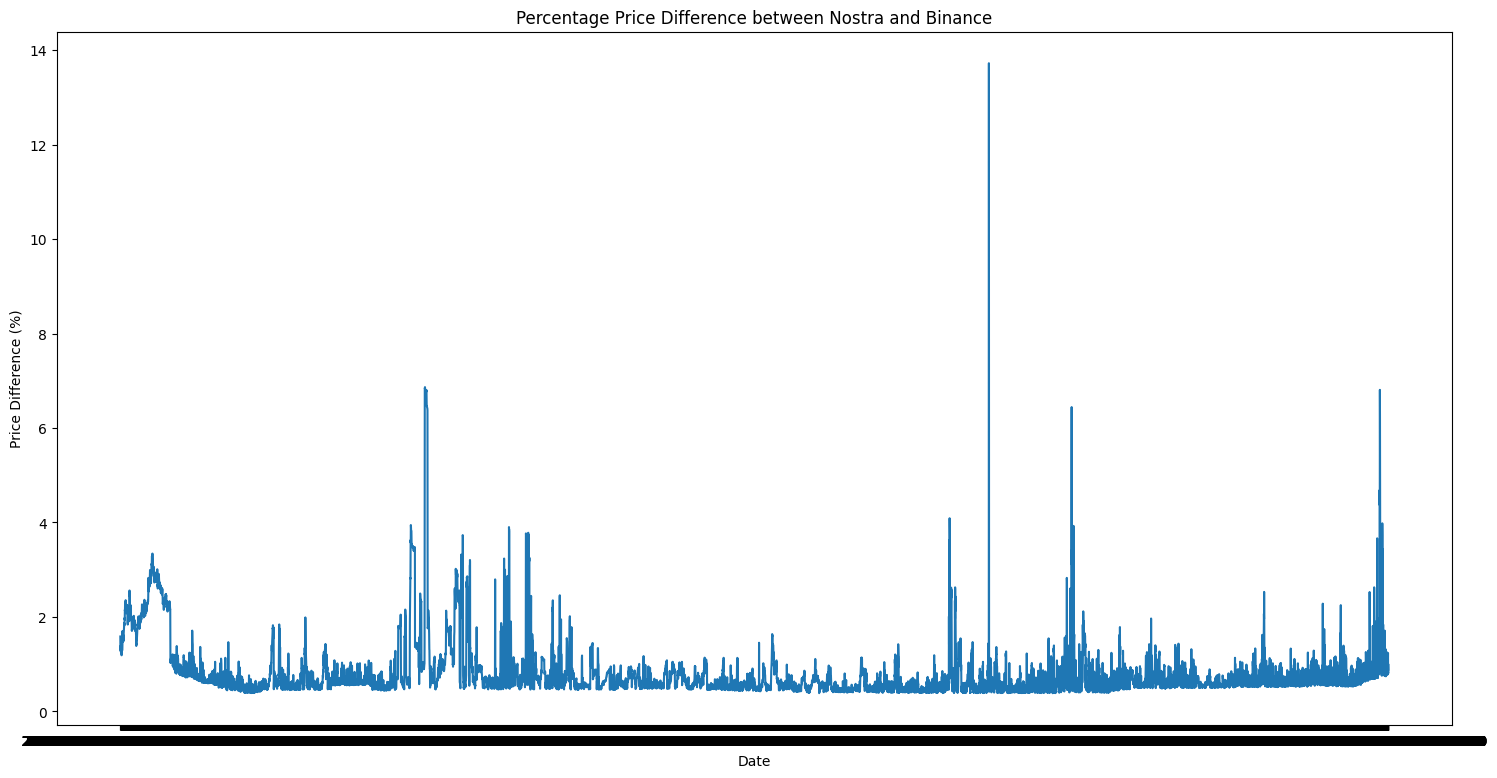

In [107]:
plt.figure(figsize=(18, 9))
plt.plot(upper_outliers['datetime_utc'], upper_outliers['delta_%'])
plt.title('Percentage Price Difference between Nostra and Binance')
plt.ylabel('Price Difference (%)')
plt.xlabel('Date')
plt.show()
